In [ ]:
! pip install JasonUtils
! pip install sklearn_som
! pip install codetiming
! pip install mlxtend

### Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from collections import defaultdict
from JasonUtils.TicToc import timing
import sklearn.externals as extjoblib
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS 
from sklearn_som.som import SOM
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Load Dataset

In [ ]:
rs = 0
df = pd.read_csv(f'/content/gdrive/MyDrive/dataset/MCSDatasetNEXTCONLab.csv')
df['Ligitimacy'] = df['Ligitimacy'].replace(0,-1)
training = df[:10139][:]
testing = df[10139:][:]
training = training.apply(lambda x: (x-45)*10000 if x.name == 'Latitude' else x)
training = training.apply(lambda x: (x+75)*10000 if x.name == 'Longitude' else x)
testing = testing.apply(lambda x: (x-45)*10000 if x.name == 'Latitude' else x)
testing = testing.apply(lambda x: (x+75)*10000 if x.name == 'Longitude' else x)
y_train = training['Ligitimacy'].values
y_test = testing['Ligitimacy'].values
X_train = training.drop(columns=['ID', 'Day', 'Ligitimacy']).values
X_test = testing.drop(columns=['ID', 'Day', 'Ligitimacy']).values
display(df.head())
print('Size of the training data : ', len(training))
print('Size of the testing data : ', len(testing))

,ID,Latitude,Longitude,Day,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber,Ligitimacy
0,1,45.442142,-75.303369,1,4,13,40,40,9,91,0,131380,1
1,1,45.442154,-75.304366,1,4,23,40,30,9,91,0,131380,1
2,1,45.442104,-75.303963,1,4,33,40,20,9,91,0,121996,1
3,1,45.441868,-75.303577,1,4,43,40,10,9,91,0,121996,1
4,2,45.447727,-75.147722,2,15,49,30,30,5,47,0,140784,1


Size of the training data :  10139
Size of the testing data :  4345


In [ ]:
df.Ligitimacy.value_counts()

 1    12587
-1     1897
Name: Ligitimacy, dtype: int64

Text(0, 0.5, 'Count')

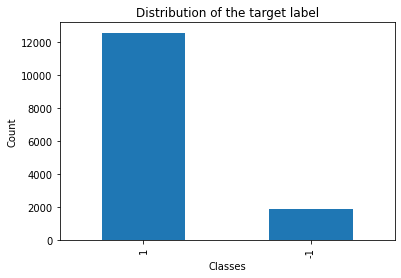

In [ ]:
df.Ligitimacy.value_counts().plot(kind='bar');
plt.title('Distribution of the target label')
plt.xlabel('Classes')
plt.ylabel('Count')

### **(1)** Apply only three of the following ML methods on the provided dataset to obtain baseline performance. Plot confusion matrix and calculate the accuracy for each methods, and plot them in a bar-chart as baseline.

In [37]:
def build_model(model, X_train, X_test, y_train, y_test):
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  test_accuracy = accuracy_score(y_test, y_pred) 
  print("\n testing accuracy :  "  ,round(test_accuracy,3),"\n")
  print(classification_report(y_test, y_pred))
  plot_confusion_matrix(model, X_test, y_test, xticks_rotation='vertical', cmap=plt.cm.OrRd);
  return test_accuracy

#### **(1.1)** LogisticRegression


 testing accuracy :   0.863 

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345



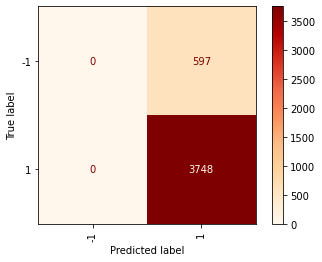

In [38]:
LR_model = LogisticRegression()
lr_baseline_acc = build_model(LR_model,X_train, X_test, y_train, y_test)

#### **(1.2)** Support Vector Machine (SVM)


 testing accuracy :   0.863 

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345



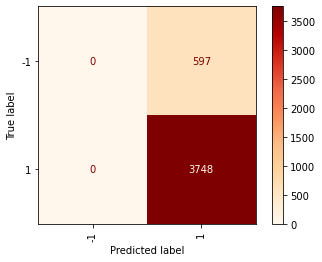

In [39]:
svm_model = svm.SVC(kernel='rbf')
svm_baseline_acc = build_model(svm_model,X_train, X_test, y_train, y_test)

#### **(1.3)** AdaBoostClassifier


 testing accuracy :   0.981 

              precision    recall  f1-score   support

          -1       0.97      0.89      0.93       597
           1       0.98      1.00      0.99      3748

    accuracy                           0.98      4345
   macro avg       0.98      0.94      0.96      4345
weighted avg       0.98      0.98      0.98      4345



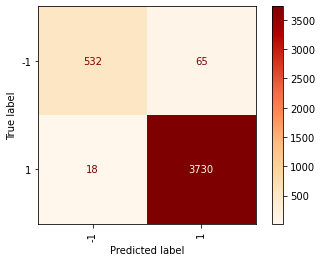

In [40]:
boost_model = AdaBoostClassifier(n_estimators=300, random_state=0)
ada_baseline_acc = build_model(boost_model,X_train, X_test, y_train, y_test)

#### baseline bar-chart

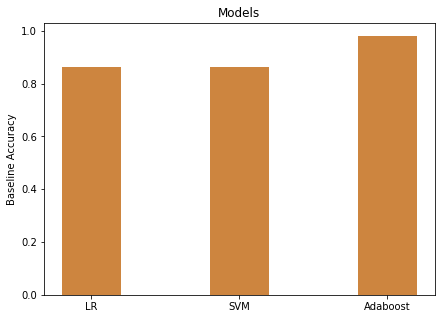

In [41]:
plt.figure(figsize=(7,5))
objects = ('LR', 'SVM', 'Adaboost')
y_pos = np.arange(len(objects))

plt.bar(y_pos, [lr_baseline_acc, svm_baseline_acc, ada_baseline_acc], align='center', color = 'peru' , width = 0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Baseline Accuracy')
plt.title('Models')
plt.show()

### **(2)** To study the impact of over/under-sampling, try the following over under-sampling methods for the 3 ML methods selected from Q1

#### **(2.1)** Synthetic Minority Oversampling Technique (SMOTE)


In [42]:
oversample = SMOTE(random_state=42)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
before = Counter(y_train)
after = Counter(y_train_over)
print('the ratio of data before SMOTE is: ' , before)
print('the ratio of data after SMOTE is: ' , after)

the ratio of data before SMOTE is:  Counter({1: 8839, -1: 1300})
the ratio of data after SMOTE is:  Counter({1: 8839, -1: 8839})


##### **(2.1.1)** LR with SMOTE


 testing accuracy :   0.58 

              precision    recall  f1-score   support

          -1       0.21      0.72      0.32       597
           1       0.92      0.56      0.70      3748

    accuracy                           0.58      4345
   macro avg       0.57      0.64      0.51      4345
weighted avg       0.83      0.58      0.64      4345



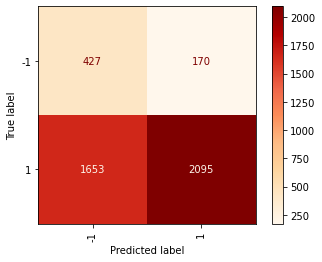

In [43]:
LR_model_smote = LogisticRegression()
lr_smote_acc = build_model(LR_model_smote, X_train_over, X_test, y_train_over, y_test)

##### **(2.1.2)** SVM with SMOTE


 testing accuracy :   0.445 

              precision    recall  f1-score   support

          -1       0.15      0.65      0.24       597
           1       0.88      0.41      0.56      3748

    accuracy                           0.45      4345
   macro avg       0.52      0.53      0.40      4345
weighted avg       0.78      0.45      0.52      4345



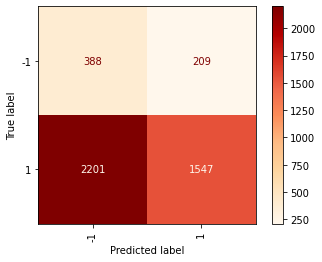

In [44]:
svm_model_smote = svm.SVC(kernel='rbf')
svm_smote_acc = build_model(svm_model_smote, X_train_over, X_test, y_train_over, y_test)

##### **(2.1.3)** Adaboost with SMOTE


 testing accuracy :   0.978 

              precision    recall  f1-score   support

          -1       0.92      0.91      0.92       597
           1       0.99      0.99      0.99      3748

    accuracy                           0.98      4345
   macro avg       0.95      0.95      0.95      4345
weighted avg       0.98      0.98      0.98      4345



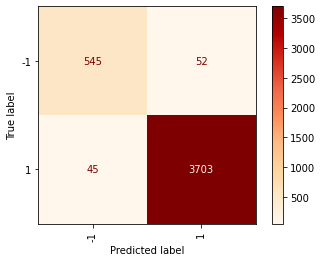

In [45]:
boost_model_smote = AdaBoostClassifier(n_estimators=300)
ada_smote_acc = build_model(boost_model_smote,X_train_over, X_test, y_train_over, y_test)

#### **(2.2)** Adaptive Synthetic Sampling (ADASYN)

In [46]:
oversample2 = ADASYN(random_state=42)
X_train_over2, y_train_over2 = oversample2.fit_resample(X_train, y_train)
before2 = Counter(y_train)
after2 = Counter(y_train_over2)
print('the ratio of data before SMOTE is: ', before2)
print('the ratio of data after SMOTE is: ', after2)

the ratio of data before SMOTE is:  Counter({1: 8839, -1: 1300})
the ratio of data after SMOTE is:  Counter({-1: 8879, 1: 8839})


##### **(2.2.1)** LR with ADASYN


 testing accuracy :   0.623 

              precision    recall  f1-score   support

          -1       0.21      0.65      0.32       597
           1       0.92      0.62      0.74      3748

    accuracy                           0.62      4345
   macro avg       0.57      0.63      0.53      4345
weighted avg       0.82      0.62      0.68      4345



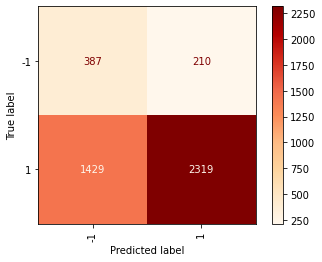

In [47]:
LR_model_adasyn = LogisticRegression()
lr_adasyn_acc = build_model(LR_model_adasyn, X_train_over2, X_test, y_train_over2, y_test)

##### **(2.2.2)** SVM with ADASYN


 testing accuracy :   0.542 

              precision    recall  f1-score   support

          -1       0.14      0.43      0.21       597
           1       0.86      0.56      0.68      3748

    accuracy                           0.54      4345
   macro avg       0.50      0.50      0.44      4345
weighted avg       0.76      0.54      0.61      4345



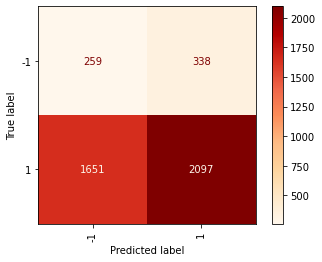

In [48]:
svm_model_adasyn = svm.SVC(kernel='rbf')
svm_adasyn_acc = build_model(svm_model_adasyn, X_train_over2, X_test, y_train_over2, y_test)

##### **(2.2.3)** Adaboost with ADASYN


 testing accuracy :   0.974 

              precision    recall  f1-score   support

          -1       0.90      0.92      0.91       597
           1       0.99      0.98      0.98      3748

    accuracy                           0.97      4345
   macro avg       0.94      0.95      0.95      4345
weighted avg       0.97      0.97      0.97      4345



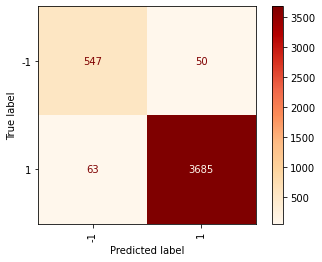

In [49]:
boost_model_adasyn = AdaBoostClassifier(n_estimators=300)
ada_adasyn_acc = build_model(boost_model_adasyn,X_train_over2, X_test, y_train_over2, y_test)

#### **(2.3)** Random Undersampling

In [50]:
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
before3 = Counter(y_train)
after3 = Counter(y_train_under)
print('the ratio of data before SMOTE is: ', before3)
print('the ratio of data after SMOTE is: ', after3)

the ratio of data before SMOTE is:  Counter({1: 8839, -1: 1300})
the ratio of data after SMOTE is:  Counter({-1: 1300, 1: 1300})


##### **(2.3.1)** LR with Random Undersampling


 testing accuracy :   0.599 

              precision    recall  f1-score   support

          -1       0.20      0.66      0.31       597
           1       0.92      0.59      0.72      3748

    accuracy                           0.60      4345
   macro avg       0.56      0.62      0.51      4345
weighted avg       0.82      0.60      0.66      4345



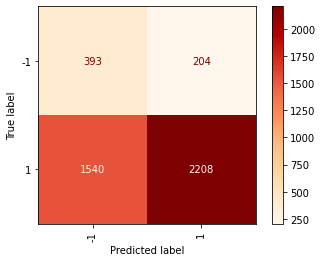

In [51]:
LR_model_under = LogisticRegression()
lr_under_acc = build_model(LR_model_under, X_train_under, X_test, y_train_under, y_test)

##### **(2.3.2)** SVM with Random Undersampling


 testing accuracy :   0.445 

              precision    recall  f1-score   support

          -1       0.15      0.65      0.24       597
           1       0.88      0.41      0.56      3748

    accuracy                           0.45      4345
   macro avg       0.52      0.53      0.40      4345
weighted avg       0.78      0.45      0.52      4345



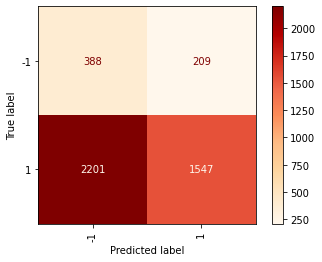

In [52]:
svm_model_under = svm.SVC(kernel='rbf')
svm_under_acc = build_model(svm_model_under, X_train_under, X_test, y_train_under, y_test)

##### **(2.3.3)** Adaboost with UnderSampling


 testing accuracy :   0.974 

              precision    recall  f1-score   support

          -1       0.86      0.97      0.91       597
           1       1.00      0.97      0.98      3748

    accuracy                           0.97      4345
   macro avg       0.93      0.97      0.95      4345
weighted avg       0.98      0.97      0.97      4345



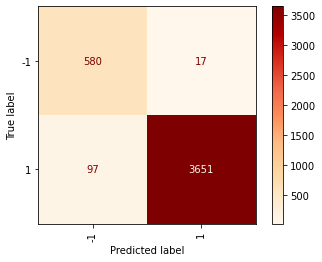

In [53]:
boost_model_under= AdaBoostClassifier(n_estimators=300)
ada_under_acc = build_model(boost_model_under,X_train_under, X_test, y_train_under, y_test)

###### based on the accurracy the most suitable over/under-sampling method for each ML model is the following :-


1.   Logisitic Regression ===> ADASYN (62%)
2.   Support Vector Machine ===> ADASYN (54%)
3.   Adaboosting Calssifier ===> SMOTE (97.8%)



#### Accuracy vs over/under-sampling methods

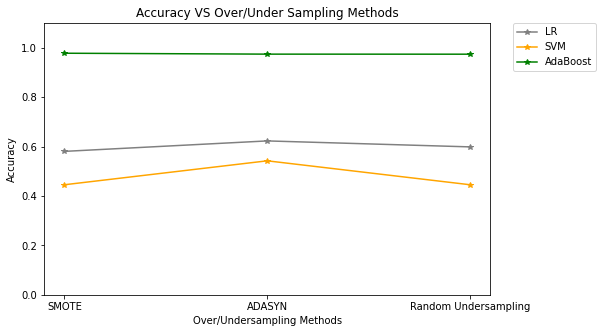

In [54]:
plt.figure(figsize=(8,5)) 
axis_values = [[lr_smote_acc, lr_adasyn_acc, lr_under_acc],
               [svm_smote_acc, svm_adasyn_acc, svm_under_acc],
               [ada_smote_acc, ada_adasyn_acc, ada_under_acc]]
values = ['SMOTE', 'ADASYN', 'Random Undersampling']
axis_1 = plt.plot(values, axis_values[0], color='gray', marker='*', 
                         linestyle='-', label = 'LR')
axis_2 = plt.plot(values, axis_values[1], color='orange', marker='*',
                         linestyle='-', label = 'SVM')
axis_3 = plt.plot(values, axis_values[2], color='green', marker='*',
                         linestyle='-', label = 'AdaBoost')
plt.title('Accuracy VS Over/Under Sampling Methods')
plt.xlabel('Over/Undersampling Methods')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

#### bar-chart of base accuracy and over/under sampling

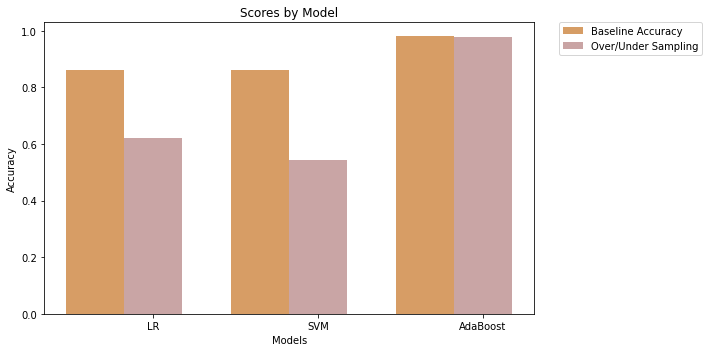

In [55]:
n_groups = 3
baseline_acc_1 = [lr_baseline_acc, svm_baseline_acc, ada_baseline_acc]
over_sample_acc = [lr_adasyn_acc, svm_adasyn_acc, ada_smote_acc]

# create plot
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

plt.bar(index, baseline_acc_1, bar_width, alpha=opacity,color='peru', label='Baseline Accuracy')
plt.bar(index + bar_width, over_sample_acc, bar_width, alpha=opacity, color='rosybrown', label='Over/Under Sampling')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Scores by Model')
plt.xticks(index + bar_width, ('LR', 'SVM', 'AdaBoost'))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

### **(3)** To improve model performances, apply one of the following feature selection and dimension reduction methods as a preprocessing step. By using the chosen method, obtain best 3~10 feature/dimension combinations.

#### **(3.2)** Principal Component Analysis  (PCA)

In [56]:
def apply_pca(estimator, X_train, y_train, X_test, y_test):
  pca_accuracy = dict()
  X_train_pca_list = dict()
  for i  in range(3,11):
    pca =PCA(n_components = i)
    X_train_pca= pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    model_pca = estimator.fit(X_train_pca,y_train)
    y_pred_pca = model_pca.predict(X_test_pca)
    test_accuracy_pca = accuracy_score(y_test, y_pred_pca) 
    X_train_pca_list[i] = X_train_pca
    pca_accuracy[i] = test_accuracy_pca
  return pca_accuracy, X_train_pca_list, model_pca

In [57]:
def plot_num_features_accuracy_pca(pca_accuracy_dict, model_name):
  best_number_of_features_pca = max(pca_accuracy_dict, key=pca_accuracy_dict.get)
  best_accuracy_pca = pca_accuracy_dict[max(pca_accuracy_dict)]
  print("Maximum accuracy of " +model_name+ " based on PCA  :", best_accuracy_pca)
  print("Best number of Components:", best_number_of_features_pca,'\n')
  scores_pca = sorted(pca_accuracy_dict.items()) # sorted by key, return a list of tuples
  x_pca, y_pca = zip(*scores_pca) # unpack a list of pairs into two tuples
  plt.plot(x_pca, y_pca, marker = 'o')
  plt.title('PCA with '+ model_name)
  plt.xlabel("Num of Components")
  plt.ylabel('Accuracy Score')
  plt.ylim(0,1.1)
  plt.xlim(3,10)
  plt.show()
  return best_number_of_features_pca, best_accuracy_pca

##### Plot t-SNE 2D figures before applying PCA

Text(0.5, 1.0, 't-SNE 2D figures before applying PCA')

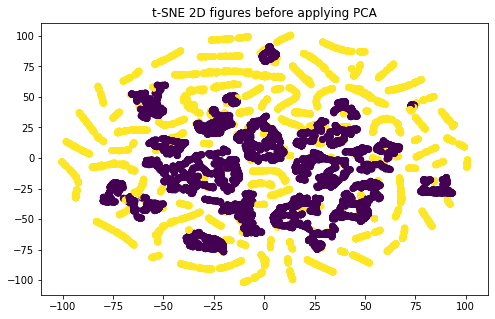

In [58]:
t_sne = TSNE(2, random_state=0)
X_train_tsne_before = t_sne.fit_transform(X_train_over2)
plt.figure(figsize=(8,5))
plt.scatter(X_train_tsne_before[:, 0], X_train_tsne_before[:, 1], c=y_train_over2, cmap='viridis');
plt.title('t-SNE 2D figures before applying PCA')

##### **(3.2.1)** Applying PCA with LR

Maximum accuracy of Logisitc Regression based on PCA  : 0.6602991944764096
Best number of Components: 9 



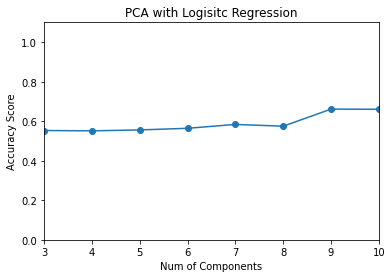

In [59]:
acc_lr_pca, X_train_pca_lr_list, model_pca_lr = apply_pca(LogisticRegression(),X_train_over2,y_train_over2,X_test, y_test)
best_number_lr_pca, best_acc_lr_pca = plot_num_features_accuracy_pca(acc_lr_pca,'Logisitc Regression')

##### **(3.2.2)** Applying PCA with SVM

Maximum accuracy of SVM based on PCA  : 0.6361334867663981
Best number of Components: 3 



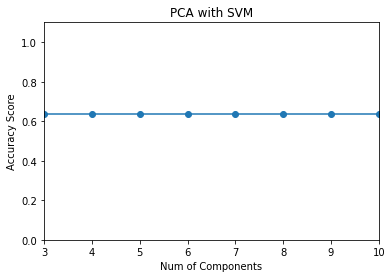

In [60]:
acc_svm_pca, X_train_pca_svm_list, model_pca_svm = apply_pca(svm.SVC(kernel='rbf'),X_train_over,y_train_over,X_test, y_test)
best_number_svm_pca, best_acc_svm_pca = plot_num_features_accuracy_pca(acc_svm_pca,'SVM')

##### **(3.2.3)** Applying PCA with Adaboost

Maximum accuracy of Adaboost based on PCA  : 0.9767548906789413
Best number of Components: 9 



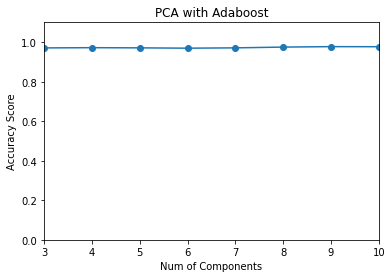

In [61]:
acc_ada_pca, X_train_pca_ada_list, model_pca_ada = apply_pca(AdaBoostClassifier(n_estimators=300),X_train_over,y_train_over,X_test, y_test)
best_number_ada_pca, best_acc_ada_pca = plot_num_features_accuracy_pca(acc_ada_pca,'Adaboost')

##### Plot t-SNE 2D figures after applying PCA

Text(0.5, 1.0, 't-SNE 2D figures before applying PCA')

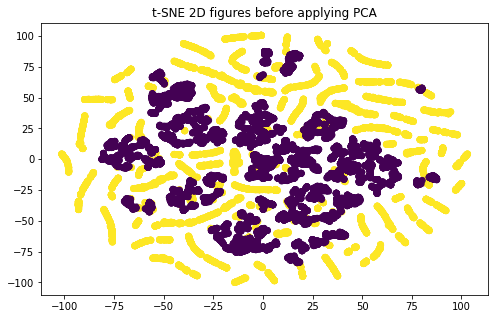

In [62]:
t_sne = TSNE(2, random_state=0)
X_train_tsne_after = t_sne.fit_transform(X_train_pca_ada_list[best_number_ada_pca])
plt.figure(figsize=(8,5))
plt.scatter(X_train_tsne_after[:, 0], X_train_tsne_after[:, 1], c=y_train_over, cmap='viridis');
plt.title('t-SNE 2D figures after applying PCA')

#### bar-chart of base accuracy, over/under sampling and dimensionality reduction

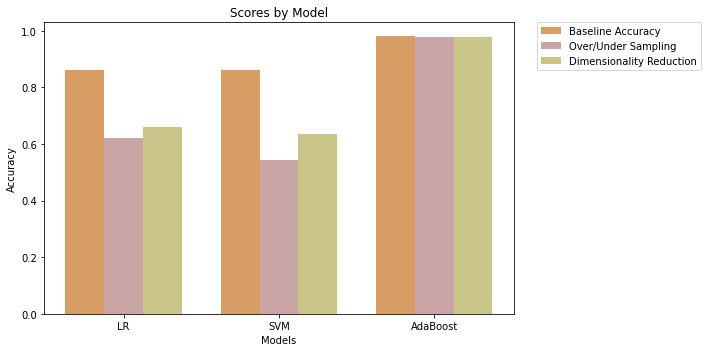

In [ ]:
n_groups = 3
baseline_acc_1 = [lr_baseline_acc, svm_baseline_acc, ada_baseline_acc]
over_sample_acc = [lr_adasyn_acc, svm_adasyn_acc, ada_smote_acc]
dim_reduction = [best_acc_lr_pca, best_acc_svm_pca, best_acc_ada_pca]

# create plot
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

plt.bar(index, baseline_acc_1, bar_width, alpha=opacity,color='peru', label='Baseline Accuracy' )
plt.bar(index + bar_width, over_sample_acc, bar_width, alpha=opacity, color='rosybrown', label='Over/Under Sampling')
plt.bar(index + 2 * bar_width, dim_reduction, bar_width, alpha=opacity, color='darkkhaki', label='Dimensionality Reduction' )

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Scores by Model')
plt.xticks(index + bar_width, ('LR', 'SVM', 'AdaBoost'))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

### **(4)** Apply stacking strategy to combine the fine-tuned models from previous step. Compare this results with baseline results and all results obtained from previous steps. Plot the confusion matrix and the bar-chart to show the improvement after each question in terms of accuracy.

In [ ]:
base_estimaters = list()
base_estimaters.append(('LR',model_pca_lr))
base_estimaters.append(('SVM' ,model_pca_svm))
base_estimaters.append(('AdaBoost', model_pca_ada))

#### **(4.1)** Aggregate based on LR 


 testing accuracy :   0.774 

              precision    recall  f1-score   support

          -1       0.36      0.81      0.50       597
           1       0.96      0.77      0.85      3748

    accuracy                           0.77      4345
   macro avg       0.66      0.79      0.68      4345
weighted avg       0.88      0.77      0.81      4345



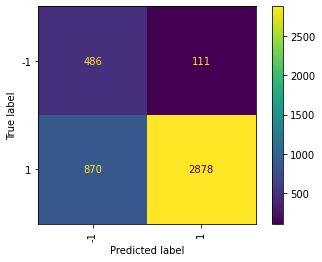

In [ ]:
st_model1 = StackingClassifier(estimators=base_estimaters, final_estimator=LogisticRegression(), cv=5)
pipe1 = Pipeline([('pca', PCA(n_components=9)), ('stacking_lr', st_model1)])
pipe1.fit(X_train_over2, y_train_over2)
y_pred_stacking1 = pipe1.predict(X_test)
test_accuracy_stacking1 = accuracy_score(y_test, y_pred_stacking1) 
print("\n testing accuracy :  "  ,round(test_accuracy_stacking1,3),"\n")
print(classification_report(y_test, y_pred_stacking1))
plot_confusion_matrix(pipe1, X_test, y_test, xticks_rotation='vertical');

#### **(4.2)** Aggregate based on SVM


 testing accuracy :   0.751 

              precision    recall  f1-score   support

          -1       0.34      0.83      0.48       597
           1       0.96      0.74      0.84      3748

    accuracy                           0.75      4345
   macro avg       0.65      0.78      0.66      4345
weighted avg       0.88      0.75      0.79      4345



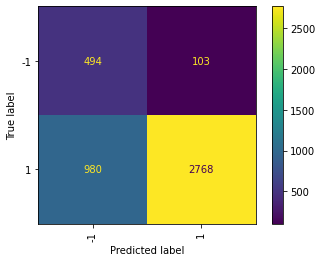

In [ ]:
st_model2 = StackingClassifier(estimators=base_estimaters, final_estimator=svm.SVC(kernel = 'rbf'), cv=5)
pipe2 = Pipeline([('pca', PCA(n_components=3)), ('stacking_svm', st_model2)])
pipe2.fit(X_train_over, y_train_over)
y_pred_stacking2 = pipe2.predict(X_test)
test_accuracy_stacking2 = accuracy_score(y_test, y_pred_stacking2) 
print("\n testing accuracy :  "  ,round(test_accuracy_stacking2,3),"\n")
print(classification_report(y_test, y_pred_stacking2))
plot_confusion_matrix(pipe2, X_test, y_test, xticks_rotation='vertical');

#### **(4.3)** Aggregate based on AdaBoost


 testing accuracy :   0.98 

              precision    recall  f1-score   support

          -1       0.93      0.92      0.92       597
           1       0.99      0.99      0.99      3748

    accuracy                           0.98      4345
   macro avg       0.96      0.95      0.96      4345
weighted avg       0.98      0.98      0.98      4345



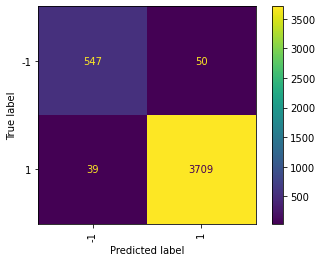

In [ ]:
st_model3 = StackingClassifier(estimators=base_estimaters, final_estimator=AdaBoostClassifier(n_estimators=300), cv=5)
pipe3 = Pipeline([('pca', PCA(n_components=9)), ('stacking_ada', st_model3)])
pipe3.fit(X_train_over, y_train_over)
y_pred_stacking3 = pipe3.predict(X_test)
test_accuracy_stacking3 = accuracy_score(y_test, y_pred_stacking3) 
print("\n testing accuracy :  "  ,round(test_accuracy_stacking3,3),"\n")
print(classification_report(y_test, y_pred_stacking3))
plot_confusion_matrix(pipe3, X_test, y_test, xticks_rotation='vertical');

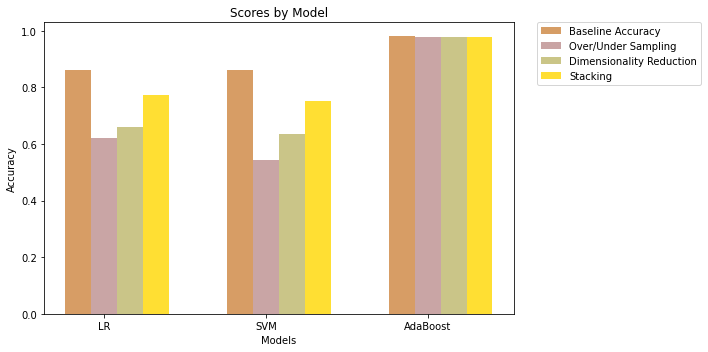

In [ ]:
n_groups = 3
baseline_acc_1 = [lr_baseline_acc, svm_baseline_acc, ada_baseline_acc]
over_sample_acc = [lr_adasyn_acc, svm_adasyn_acc, ada_smote_acc]
dim_reduction = [best_acc_lr_pca, best_acc_svm_pca, best_acc_ada_pca]
stacking_acc = [test_accuracy_stacking1, test_accuracy_stacking2, test_accuracy_stacking3]

# create plot
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.16
opacity = 0.8

plt.bar(index, baseline_acc_1, bar_width, alpha=opacity,color='peru', label='Baseline Accuracy')
plt.bar(index + bar_width, over_sample_acc, bar_width, alpha=opacity, color='rosybrown', label='Over/Under Sampling')
plt.bar(index + 2 * bar_width, dim_reduction, bar_width, alpha=opacity, color='darkkhaki', label='Dimensionality Reduction')
plt.bar(index + 3 * bar_width, stacking_acc, bar_width, alpha=opacity, color='gold', label='Stacking')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Scores by Model')
plt.xticks(index + bar_width, ('LR', 'SVM', 'AdaBoost'))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

## Part 2


Apply scaling to features (e.g. MinMaxScaler) before training your models. Some of the hyperparameters are given below for MLPclassifier. You should find the suitable values for other important parameters (e.g. learning rate, momentum). Each MLPclassifier should be run 10 times (trained and tested 10 times) and average accuracy should be provided to eliminate the effect of random initial conditions in MLP


### **(5)** Apply scaling to features (e.g. MinMaxScaler) before training your models.

In [ ]:
scaler = MinMaxScaler()
SC1= scaler.fit(X_train)
X_train_2 = SC1.transform(X_train)

SC2 = scaler.fit(X_test) # why x_train !!!
X_test_2 = SC2.transform(X_test)

y_train_2 = y_train
y_test_2 = y_test 

#### **(5.1)** Apply MLP classifier to original data,provide the accuracy and plot the confusion matrix. This is your baseline performance for MLP classifier.

In [ ]:
mlp_grid = MLPClassifier(hidden_layer_sizes=(15,15), 
                    solver='sgd', 
                    batch_size=200,  
                    max_iter=100)
parameter_space = {'activation':['tanh','relu'],
    'learning_rate': ['constant','adaptive'],
    'momentum' : [0.7,0.9],
    'learning_rate_init' : [0.1, 0.01 ,0.001]}

clf = GridSearchCV(mlp_grid, parameter_space, n_jobs=-1, cv=4)
clf.fit(X_train_2 ,y_train_2)

GridSearchCV(cv=4,
             estimator=MLPClassifier(batch_size=200,
                                     hidden_layer_sizes=(15, 15), max_iter=100,
                                     solver='sgd'),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'learning_rate': ['constant', 'adaptive'],
                         'learning_rate_init': [0.1, 0.01, 0.001],
                         'momentum': [0.7, 0.9]})

In [ ]:
print(" best parameters :\n" , clf.best_params_)

 best parameters :
 {'activation': 'relu', 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'momentum': 0.9}


In [ ]:
MLP = MLPClassifier(hidden_layer_sizes=(15,15), 
                    activation='relu',
                    solver='sgd',
                    learning_rate = 'constant', 
                    batch_size=200,  
                    max_iter=300,
                    learning_rate_init = 0.01,
                    momentum=0.9)

In [ ]:

## run 10 times and average take the accuracy to eliminate the effect of random initial conditions in MLP
Accuracies = []
for i in range(10):
  mlp = MLP.fit(X_train_2, y_train_2)
  mlp_pred_base = mlp.predict(X_test_2)
  accuracy = accuracy_score(y_test_2, mlp_pred_base)
  Accuracies.append(accuracy)

Accuracies

[0.8697353279631761,
 0.8754890678941312,
 0.8699654775604143,
 0.8695051783659379,
 0.8734177215189873,
 0.8731875719217491,
 0.8699654775604143,
 0.8695051783659379,
 0.8913693901035673,
 0.8787111622554661]

In [ ]:
base_accuracy = np.mean(Accuracies)
base_accuracy

0.8740851553509781

the base accuracy:  0.8740851553509781 

              precision    recall  f1-score   support

          -1       0.61      0.34      0.43       597
           1       0.90      0.97      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.75      0.65      0.68      4345
weighted avg       0.86      0.88      0.86      4345



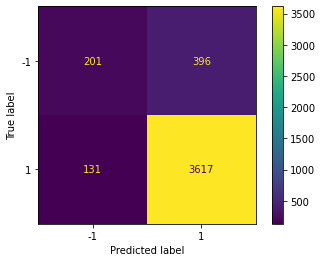

In [ ]:
base_accuracy = np.mean(Accuracies)
cm = confusion_matrix(y_test, mlp_pred_base, labels=MLP.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=MLP.classes_)
print("the base accuracy: "  ,base_accuracy ,"\n" )
print(classification_report(y_test_2, mlp_pred_base))
disp.plot()
plt.show()

#### **(5.2)** Find the best feature combination for MLP model by using wrapper method from Q1 based on the testing accuracy of MLP. Train an MLP classifier on this dataset. Plot the number of features (X-axis) versus accuracy (Y-axis) graph with baseline performance. Provide the accuracy and plot the confusion matrix for the best results. This is your first step to improve baseline performance.

In [ ]:
sfs = SFS(MLP ,
          k_features = 10 ,
          forward = True,
          floating = False ,
          scoring = 'accuracy',
          verbose = 2 )
sfs.fit(X_train_2 , y_train_2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   45.5s finished

[2021-12-13 03:12:10] Features: 1/10 -- score: 0.8717822220535589[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   59.8s finished

[2021-12-13 03:13:09] Features: 2/10 -- score: 0.8718808413829476[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.4min finished

[2021-12-13 03:15:35] Features: 3/10 -- score: 0.8796731306844775[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(estimator=MLPClassifier(batch_size=200,
                                                  hidden_layer_sizes=(15, 15),
                                                  learning_rate_init=0.01,
                                                  max_iter=300, solver='sgd'),
                          k_features=10, scoring='accuracy', verbose=2)

In [ ]:
df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()
df_SFS_results

,feature_idx,cv_scores,avg_score,feature_names
1,"(0,)","[0.8717948717948718, 0.8717948717948718, 0.871...",0.871782,"(0,)"
2,"(0, 2)","[0.8717948717948718, 0.8722879684418146, 0.871...",0.871881,"(0, 2)"
3,"(0, 2, 6)","[0.8742603550295858, 0.8791913214990138, 0.877...",0.879673,"(0, 2, 6)"
4,"(0, 1, 2, 6)","[0.8801775147928994, 0.893491124260355, 0.8703...",0.888452,"(0, 1, 2, 6)"
5,"(0, 1, 2, 4, 6)","[0.8925049309664694, 0.8816568047337278, 0.880...",0.892101,"(0, 1, 2, 4, 6)"
6,"(0, 1, 2, 4, 6, 9)","[0.893491124260355, 0.8831360946745562, 0.8880...",0.889832,"(0, 1, 2, 4, 6, 9)"
7,"(0, 1, 2, 3, 4, 6, 9)","[0.900887573964497, 0.8974358974358975, 0.8875...",0.895257,"(0, 1, 2, 3, 4, 6, 9)"
8,"(0, 1, 2, 3, 4, 5, 6, 9)","[0.8865877712031558, 0.8974358974358975, 0.874...",0.89072,"(0, 1, 2, 3, 4, 5, 6, 9)"
9,"(0, 1, 2, 3, 4, 5, 6, 7, 9)","[0.9048323471400395, 0.8801775147928994, 0.877...",0.884702,"(0, 1, 2, 3, 4, 5, 6, 7, 9)"
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[0.8851084812623274, 0.8708086785009862, 0.876...",0.880561,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)"


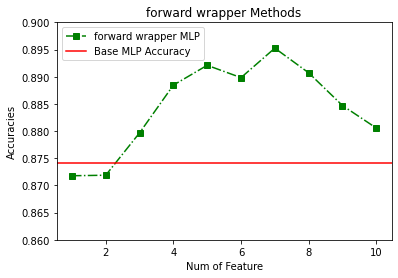

In [ ]:
plt.plot(df_SFS_results.index , df_SFS_results.avg_score, marker = 's' , color = 'g',linestyle ='-.' , label = "forward wrapper MLP")
plt.axhline(y=base_accuracy , color='r', linestyle='-' , label = "Base MLP Accuracy")
plt.title('forward wrapper Methods')
plt.xlabel("Num of Feature")
plt.ylabel('Accuracies')
plt.ylim(0.86 ,0.9)
plt.legend()
plt.show()

In [ ]:
df_sfs = df_SFS_results[df_SFS_results.avg_score == max(df_SFS_results.avg_score)]
display(df_sfs)

,feature_idx,cv_scores,avg_score,feature_names
7,"(0, 1, 2, 3, 4, 6, 9)","[0.900887573964497, 0.8974358974358975, 0.8875...",0.895257,"(0, 1, 2, 3, 4, 6, 9)"


accuracy with wrapper :  0.8952565902719597
              precision    recall  f1-score   support

          -1       0.51      0.33      0.40       597
           1       0.90      0.95      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.70      0.64      0.66      4345
weighted avg       0.85      0.86      0.85      4345



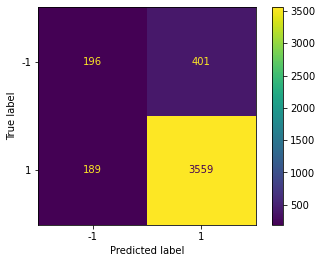

In [ ]:
l1 = df_sfs.feature_idx.to_list()
l1= list(l1[0])

X_train_wr= X_train_2[:,l1]
X_test_wr = X_test_2[:,l1]
MLP_wr = MLP.fit(X_train_wr, y_train_2)
mlp_pred_wr = MLP_wr.predict(X_test_wr)
base_accuracy_2 = np.array(df_sfs.avg_score)[0]
print("accuracy with wrapper : " , base_accuracy_2)
cm_wr= confusion_matrix(y_test_2, mlp_pred_wr, labels=MLP_wr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_wr,display_labels=MLP.classes_)
print(classification_report(y_test_2, mlp_pred_wr))
disp.plot()
plt.show()

#### **(5.3)** In this step, you will utilize PKI approach to improve performance. Cluster dataset (both training and test set) by using SOM(m=k, n=k) where (2:8). Add the obtained cluster labels as additional feature to selected features (best feature combination) in both training and test sets. Train your MLP classifier with the extra knowledge. Plot k (X-axis) versus average accuracy of 10 runs (Y-axis). Show your final accuracy from the previous question as the updated baseline

In [ ]:
print(X_train_wr.shape)
print(X_test_wr.shape)
print(y_train_2.shape)
print(y_test_2.shape)

(10139, 7)
(4345, 7)
(10139,)
(4345,)


In [ ]:
d = len(l1)
scores_for_K = []
for k in range(2,9):
  som = SOM(m = k ,n = k  ,dim = d)
  som.fit(X_train_wr)
  tr_label = som.predict(X_train_wr)
  tes_label = som.predict(X_test_wr)
  df_new_fea_train = pd.DataFrame(X_train_wr)
  df_new_fea_train["cluster"] = tr_label 
  df_new_fea_test = pd.DataFrame(X_test_wr)
  df_new_fea_test["cluster"] = tes_label 
  new_Xtrain = np.array(df_new_fea_train)
  new_Xtest  = np.array(df_new_fea_test)
  Accs = []
  for i in range(10):
    mlp = MLP.fit(new_Xtrain, y_train_2)
    mlp_pred_new = mlp.predict(new_Xtest)
    accu= accuracy_score(y_test_2, mlp_pred_new)
    Accs.append(accu)
  k_acc = np.mean(Accs)
  scores_for_K.append(k_acc)

In [ ]:
scores_for_K

[0.8845799769850403,
 0.8718066743383199,
 0.8736939010356732,
 0.8636363636363636,
 0.8681242807825086,
 0.8626006904487917,
 0.8628768699654776]

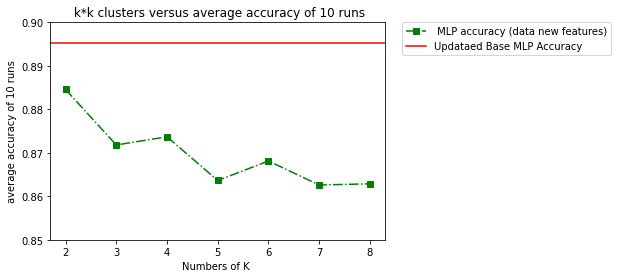

In [ ]:
plt.plot(range(2,9) , scores_for_K, label = " MLP accuracy (data new features)",
         color = 'g', linestyle ='-.' ,marker = "s" )

plt.axhline(y=base_accuracy_2 , color='r', linestyle='-' , label = "Updataed Base MLP Accuracy")
plt.title(' k*k clusters versus average accuracy of 10 runs')
plt.xlabel("Numbers of K ")
plt.ylabel('average accuracy of 10 runs')
plt.ylim(0.85 ,0.90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
base_accuracy_3 = np.max(scores_for_K)
base_accuracy_3

0.8845799769850403

In [ ]:
best_k = scores_for_K.index(max(scores_for_K))+2
best_k

2

In [ ]:
d = len(l1)
som = SOM(m = best_k ,n = best_k  ,dim = d)
som.fit(X_train_wr)
tr_label = som.predict(X_train_wr)
tes_label = som.predict(X_test_wr)


df_new_fea_train = pd.DataFrame(X_train_wr)
df_new_fea_train["cluster"] = tr_label 

df_new_fea_test = pd.DataFrame(X_test_wr)
df_new_fea_test["cluster"] = tes_label 

X= df_new_fea_train.append(df_new_fea_test)
# latset dataset 
new_Xtrain = np.array(df_new_fea_train)
new_Xtest  = np.array(df_new_fea_test)
print(new_Xtrain.shape)
print(new_Xtest.shape)
print(y_train_2.shape)
print(y_test_2.shape)

(10139, 8)
(4345, 8)
(10139,)
(4345,)


### 5.4- Tune the number of hidden layers(3-10) and number of neurons(10-30) using given values with the latest
version of the processed dataset. Plot the tuned parameters versus average testing accuracy. You
should make sure that the maximum accuracy is seen in the figure. Show your final accuracy from the
previous question as the updated baseline.(

In [ ]:
# the data that will be used in this section is 
# new_Xtrain 
# new_Xtest
# y_train_2
# y_test_2
#  base_accuracy_3   final accuracy from the previous question(5.3) as the updated baseline.


In [ ]:

import random
layers_neurons = []
for i in range(3,11):
  t = [tuple([random.randrange(10, 30,5) for j in range(i)]) for k in range(10)]
  layers_neurons.append(t)

layers_neurons

[[(15, 20, 20),
  (25, 25, 10),
  (25, 20, 25),
  (20, 25, 20),
  (15, 20, 20),
  (20, 20, 20),
  (10, 20, 10),
  (10, 10, 20),
  (25, 10, 15),
  (15, 15, 10)],
 [(10, 15, 25, 10),
  (10, 20, 20, 25),
  (10, 10, 25, 20),
  (10, 20, 15, 25),
  (25, 10, 20, 15),
  (10, 15, 25, 10),
  (25, 20, 20, 25),
  (25, 25, 25, 15),
  (25, 15, 25, 15),
  (25, 15, 10, 20)],
 [(10, 25, 20, 20, 10),
  (20, 20, 10, 15, 15),
  (25, 25, 15, 20, 10),
  (10, 10, 10, 15, 25),
  (20, 10, 10, 15, 10),
  (25, 20, 15, 10, 10),
  (25, 15, 20, 25, 10),
  (20, 15, 25, 25, 10),
  (25, 20, 10, 10, 15),
  (25, 25, 20, 25, 15)],
 [(20, 10, 20, 10, 10, 15),
  (15, 10, 20, 10, 10, 15),
  (25, 10, 20, 25, 10, 20),
  (10, 15, 20, 10, 15, 25),
  (15, 10, 20, 15, 15, 10),
  (10, 25, 20, 15, 20, 15),
  (10, 20, 25, 15, 25, 20),
  (15, 20, 20, 25, 10, 20),
  (10, 25, 25, 15, 20, 20),
  (25, 15, 15, 20, 20, 15)],
 [(25, 25, 10, 25, 10, 10, 25),
  (15, 25, 25, 25, 15, 25, 20),
  (10, 15, 10, 10, 10, 25, 10),
  (10, 15, 20, 25, 1

In [ ]:

lists = layers_neurons
values = []
for l in lists:
    acc_layers = []
    for i in range(len(l)):
        MLP_tuned = MLPClassifier(hidden_layer_sizes = l[i] ,
                            activation='relu',
                            solver='sgd',
                            learning_rate = "constant" , 
                            batch_size=200,  
                            max_iter=500,
                            learning_rate_init = 0.01,
                            momentum=0.9)

        acc_10 = []
        for i in range(10):# run 10 times
          MLP_tuned.fit(new_Xtrain ,y_train_2)
          y_pred_t = MLP_tuned.predict(new_Xtest)
          accuracy_t = accuracy_score(y_test_2 ,y_pred_t)
          acc_10.append(acc_10) 
        avg_10 = np.mean(acc_10)
        acc_layers.append(avg_10)
    avg_acc =np.mean(acc_layers) 
    n_l_size = l[acc_layers.index(max(acc_layers))]
    num_layers = len(n_l_size)
    para_value = [num_layers , n_l_size , avg_acc]
    values.append(para_value)
    

In [ ]:
values

[[3, (25, 25, 10), 0.9256616800920598],
 [4, (10, 25, 20, 10), 0.913770617568086],
 [5, (20, 25, 20, 25, 10), 0.9272727272727272],
 [6, (20, 20, 15, 25, 20, 10), 0.8900652090525508],
 [7, (15, 25, 25, 25, 10, 10, 25), 0.9159953970080553],
 [8, (25, 15, 15, 10, 15, 20, 20, 20), 0.8972765630993479],
 [9, (20, 10, 25, 10, 25, 25, 20, 25, 20), 0.916915995397008],
 [10, (10, 15, 10, 25, 15, 10, 25, 25, 20, 10), 0.871192942079018]]

In [ ]:
df_out = pd.DataFrame(values)
df_out.rename(columns={0:"N_layers" ,1:"Neurons" ,2:"Avg_accuracy"} ,inplace= True)
df_out

,N_layers,Neurons,Avg_accuracy
0,3,"(25, 25, 10)",0.925662
1,4,"(10, 25, 20, 10)",0.913771
2,5,"(20, 25, 20, 25, 10)",0.927273
3,6,"(20, 20, 15, 25, 20, 10)",0.890065
4,7,"(15, 25, 25, 25, 10, 10, 25)",0.915995
5,8,"(25, 15, 15, 10, 15, 20, 20, 20)",0.897277
6,9,"(20, 10, 25, 10, 25, 25, 20, 25, 20)",0.916916
7,10,"(10, 15, 10, 25, 15, 10, 25, 25, 20, 10)",0.871193


In [ ]:
x = list(df_out.N_layers)
y = list(df_out.Avg_accuracy)
neuron = list(df_out.Neurons)


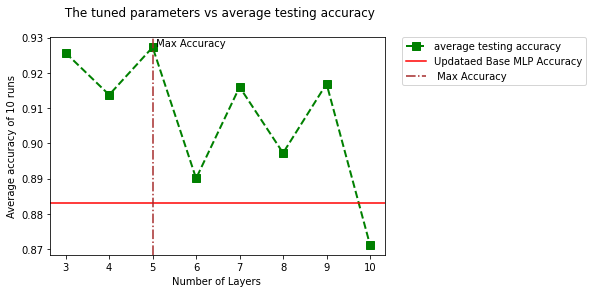

In [ ]:

plt.plot(df_out.N_layers, df_out.Avg_accuracy, color='green',
         marker='s', linestyle='dashed',
         linewidth=2, markersize=8 ,label ="average testing accuracy" )
plt.axhline(y=base_accuracy_3 , color='r', linestyle='-' , label = "Updataed Base MLP Accuracy")
plt.title(' The tuned parameters vs average testing accuracy\n')
plt.xlabel("Number of Layers ")
plt.ylabel('Average accuracy of 10 runs')
#plt.ylim(0.86 ,0.88)


plt.annotate(" Max Accuracy" ,(x[y.index(max(y))]  ,y[y.index(max(y))]+0.0002))
plt.axvline( x[y.index(max(y))] , color='brown', linestyle='-.', label=' Max Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

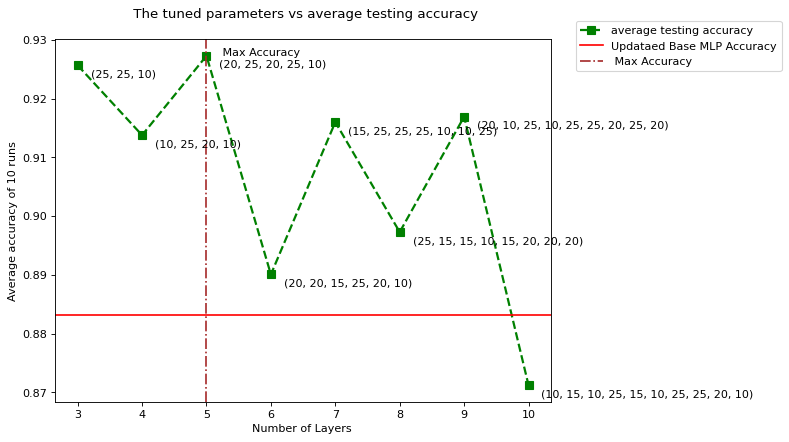

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(df_out.N_layers, df_out.Avg_accuracy, color='green',
         marker='s', linestyle='dashed',
         linewidth=2, markersize=8 ,label ="average testing accuracy" )
plt.axhline(y=base_accuracy_3 , color='r', linestyle='-' , label = "Updataed Base MLP Accuracy")
plt.title(' The tuned parameters vs average testing accuracy\n')
plt.xlabel("Number of Layers ")
plt.ylabel('Average accuracy of 10 runs')
#plt.ylim(0.86 ,0.88)
x = list(df_out.N_layers)
y = list(df_out.Avg_accuracy)
neuron = list(df_out.Neurons)
for i, txt in enumerate(neuron):
    plt.annotate(txt, (x[i]+0.2,y[i]-0.002))

plt.annotate(" Max Accuracy" ,(x[y.index(max(y))]+0.2  ,y[y.index(max(y))]))
plt.axvline( x[y.index(max(y))] , color='brown', linestyle='-.', label=' Max Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1.05), loc=2, borderaxespad=0.)
plt.show()